# Juan Ruiz Juan Ortega Juan Cerquera
# Cinematica inversa robot Irb140

### Librerias

In [215]:
import pybullet
import sympy as sp
import numpy as np
from spatialmath import SE3
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
from roboticstoolbox import jtraj, ctraj, mtraj, quintic

### DH Irb140 en clase de robotic-toolbox

In [216]:
irb140 = rtb.models.DH.IRB140()
irb140

DHRobot: IRB 140 (by ABB), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬───────┬──────┬────────┬─────────┬────────┐
│θⱼ  │  dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼───────┼──────┼────────┼─────────┼────────┤
│ q1 │ 0.352 │ 0.07 │ -90.0° │ -180.0° │ 180.0° │
│ q2 │     0 │ 0.36 │   0.0° │ -100.0° │ 100.0° │
│ q3 │     0 │    0 │ -90.0° │ -220.0° │  60.0° │
│ q4 │  0.38 │    0 │  90.0° │ -200.0° │ 200.0° │
│ q5 │     0 │    0 │ -90.0° │ -120.0° │ 120.0° │
│ q6 │ 0.065 │    0 │   0.0° │ -400.0° │ 400.0° │
└────┴───────┴──────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬─────┬──────┬───────┬─────┬──────┬──────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5   │
├─────┼─────┼──────┼───────┼─────┼──────┼──────┤
│  qr │  0° │ -90° │  90°  │  0° │  90° │ -90° │
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0°  │
│  qd │  0° │ -90° │  180° │  0° │  0°  │ -90° │
└─────┴─────┴──────┴───────┴─────┴──────┴──────┘

## Cinematica directa

In [217]:
def sTdh(d, th, a, alpha):
    cth = sp.cos(th); sth = sp.sin(th)
    ca = sp.cos(alpha); sa = sp.sin(alpha)
    Tdh = sp.Matrix([[cth, -ca*sth,  sa*sth, a*cth],
                     [sth,  ca*cth, -sa*cth, a*sth],
                     [0,        sa,     ca,      d],
                     [0,         0,      0,      1]])
    return Tdh

def Tdh(d, th, a, alpha):
    cth = np.cos(th);    sth = np.sin(th)
    ca = np.cos(alpha);  sa = np.sin(alpha)
    Tdh = np.array([[cth, -ca*sth,  sa*sth, a*cth],
                    [sth,  ca*cth, -sa*cth, a*sth],
                    [0,        sa,     ca,      d],
                    [0,         0,      0,      1]])
    return Tdh

In [218]:

def scdirecta_irb140(q, l1, l2, l3, l4, l5):

    T01 = sTdh(    l1,    q[0],   l2,   -sp.pi/2)
    T12 = sTdh(     0,    q[1],   l3,          0)
    T23 = sTdh(     0,    q[2],    0,   -sp.pi/2)
    T34 = sTdh(    l4,    q[3],    0,    sp.pi/2)
    T45 = sTdh(     0,    q[4],    0,   -sp.pi/2)
    T56 = sTdh(    l5,    q[5],    0,          0)

    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
    last_column = Tf[:, -1]
    return last_column

In [219]:
q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')
l1, l2, l3, l4, l5 = sp.symbols('l1 l2 l3 l4 l5')
q = [q1,q2,q3,q4,q5,q6]

TeS = scdirecta_irb140(q, l1, l2, l3, l4, l5)
print(TeS)

Matrix([[l2*cos(q1) + l3*cos(q1)*cos(q2) + l4*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2)) + l5*(-((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q1)*sin(q4))*sin(q5) + (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*cos(q5))], [l2*sin(q1) + l3*sin(q1)*cos(q2) + l4*(-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2)) + l5*(-((-sin(q1)*sin(q2)*sin(q3) + sin(q1)*cos(q2)*cos(q3))*cos(q4) - sin(q4)*cos(q1))*sin(q5) + (-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))*cos(q5))], [l1 - l3*sin(q2) + l4*(sin(q2)*sin(q3) - cos(q2)*cos(q3)) + l5*((sin(q2)*sin(q3) - cos(q2)*cos(q3))*cos(q5) - (-sin(q2)*cos(q3) - sin(q3)*cos(q2))*sin(q5)*cos(q4))], [1]])


In [220]:
def ncdirecta_irb140(q, l1, l2, l3, l4, l5):

    T01 = Tdh(    l1,    q[0],   l2,   -np.pi/2)
    T12 = Tdh(     0,    q[1],   l3,          0)
    T23 = Tdh(     0,    q[2],    0,   -np.pi/2)
    T34 = Tdh(    l4,    q[3],    0,    np.pi/2)
    T45 = Tdh(     0,    q[4],    0,   -np.pi/2)
    T56 = Tdh(    l5,    q[5],    0,          0)

    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
    last_column = Tf[:, -1]
    return last_column

In [221]:
l1 = 0.352
l2 = 0.07
l3 = 0.36
l4 = 0.38
l5 = 0.065
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

TeN = ncdirecta_irb140(q, l1, l2, l3, l4, l5)
TeN

array([ 0.1859542 ,  0.0308539 , -0.08930135,  1.        ])

In [222]:
T = irb140.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])  # forward kinematics
print(T)

   0.2819   -0.4934   -0.8229    0.186     
  -0.7779   -0.6196    0.1051    0.03085   
  -0.5617    0.6105   -0.5584   -0.0893    
   0         0         0         1         



### Jacobiano

In [223]:
from sympy import sin, cos, Matrix
# Definir las variables simbólicas de la función vectorial
q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')
l1, l2, l3, l4, l5 = sp.symbols('l1 l2 l3 l4 l5')

# Definir las funciones x, y, z como se indican
x = TeS[0,:]
y = TeS[1,:]
z = TeS[1,:]
X = Matrix([x,y,z])
Y = Matrix([q1, q2, q3, q4, q5])

Jacobian = X.jacobian(Y)
Jacobian


Matrix([
[  -l2*sin(q1) - l3*sin(q1)*cos(q2) + l4*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2)) + l5*(-((sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q4)*cos(q1))*sin(q5) + (sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))*cos(q5)), -l3*sin(q2)*cos(q1) + l4*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3)) + l5*((sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))*cos(q5) - (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*sin(q5)*cos(q4)), l4*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3)) + l5*((sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))*cos(q5) - (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*sin(q5)*cos(q4)), -l5*(-(-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*sin(q4) + sin(q1)*cos(q4))*sin(q5), l5*(-((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q1)*sin(q4))*cos(q5) - (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*sin(q5))],
[l2*cos(q1) + l3*cos(q1)*cos(q2) + l4*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*

## Cinematica inversa analitica

In [224]:
import numpy as np
from sympy import sin, cos
import math

# Función que realiza el cálculo de la cinemática inversa (calculado usando el método de Newton)
def cinematica_inversa_Newton(Xdeseado, Qinicial, L, max_iter=100, epsilon=1e-4):
    # Es importante usar "copy" para no sobrescribir el valor original
    q = Qinicial.copy()
    # Almacenamiento del error
    ee = []
    q1, q2, q3,q4,q5, = sp.symbols('q1 q2 q3 q4 q5')
    l1, l2, l3, l4,l5 = sp.symbols('l1 l2 l3 l4 l5')
    
    # Bucle principal
    for i in range(max_iter):    
        x = l2*cos(q1) + l3*cos(q1)*cos(q2) + l4*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2)) + l5*(-((-sin(q2)*sin(q3)*cos(q1) + cos(q1)*cos(q2)*cos(q3))*cos(q4) + sin(q1)*sin(q4))*sin(q5) + (-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))*cos(q5))
        y = l2*sin(q1) + l3*sin(q1)*cos(q2) + l4*(-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2)) + l5*(-((-sin(q1)*sin(q2)*sin(q3) + sin(q1)*cos(q2)*cos(q3))*cos(q4) - sin(q4)*cos(q1))*sin(q5) + (-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))*cos(q5))
        z = l1 - l3*sin(q2) + l4*(sin(q2)*sin(q3) - cos(q2)*cos(q3)) + l5*((sin(q2)*sin(q3) - cos(q2)*cos(q3))*cos(q5) - (-sin(q2)*cos(q3) - sin(q3)*cos(q2))*sin(q5)*cos(q4))


        X = Matrix([x,y,z])
        Y = Matrix([q1,q2,q3,q4,q5])

        J = X.jacobian(Y).subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])

        Ja = np.array(J).astype('float64')
        
        x_np = np.array(x.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        y_np = np.array(y.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        z_np = np.array(z.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        
        f = np.array([x_np, y_np, z_np])
        
        e = Xdeseado-f
    
        q = q + np.dot(np.linalg.pinv(Ja), e)
        
        enorm = np.linalg.norm(e)
        print("Error en la iteración {}: {}".format(i, np.round(enorm,4)))
        ee.append(enorm)  

        if (enorm < epsilon):
            break
    return q, ee

# Prueba de la cinemática inversa
# -------------------------------
# Parámetros del robot
l1 = 0.352
l2 = 0.07
l3 = 0.36
l4 = 0.38
l5 = 0.065
L = np.array([0.352, 0.07, 0.36,0.38, 0.065])
# Valor articular inicial
qinit = np.array([0, 0, 0, 0, 0])

# Valor x,y deseado (en el espacio cartesiano)
xd = np.array([0.186, 0.03085, -0.0893])
# Hiperparámetros
epsilon = 1e-4         # Condición para el término
max_iteraciones = 100000  # Máximo número de iteraciones
 
# Cinemática Inversa
q, e = cinematica_inversa_Newton(xd, qinit, L, max_iteraciones, epsilon)
print("\nValores articulares obtenidos:", np.round(q,4))

Error en la iteración 0: 0.246
Error en la iteración 1: 0.0685
Error en la iteración 2: 0.008


Error en la iteración 3: 0.0001

Valores articulares obtenidos: [0.1643 0.1786 0.3725 0.0024 0.0502]


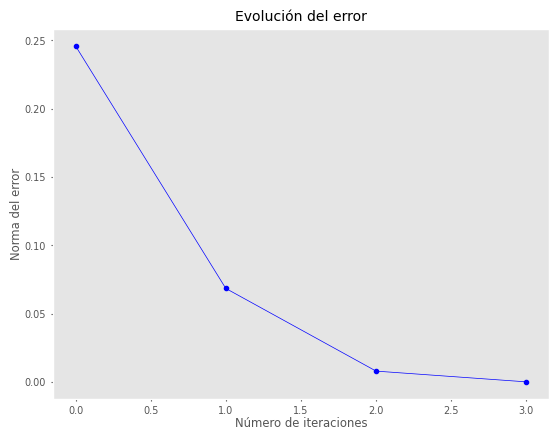

In [225]:
# Gráfico del error (debe ser decreciente)
plt.plot(e,'b')
plt.plot(e,'b.')
plt.title("Evolución del error"); plt.grid()
plt.xlabel("Número de iteraciones"); plt.ylabel("Norma del error");

## Cinematica inversa con robotic-toolbox

In [226]:
T = irb140.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
T

   0.2819   -0.4934   -0.8229    0.186     
  -0.7779   -0.6196    0.1051    0.03085   
  -0.5617    0.6105   -0.5584   -0.0893    
   0         0         0         1         


In [227]:
T = irb140.fkine([0.1643, 0.1786, 0.3725, 0.0024, 0.0502, 0.6])
T

   0.7629   -0.3262   -0.5581    0.186     
  -0.4479   -0.8893   -0.09241   0.03084   
  -0.4662    0.3205   -0.8246   -0.08929   
   0         0         0         1         


In [228]:
T = irb140.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
sol = irb140.ikine_LM(T)                          
print(sol)

IKSolution: q=[0.1, 0.2, 0.3, -2.742, -0.5, -2.542], success=True, iterations=12, searches=1, residual=1.75e-08


## Moveit

Configurar el Brazo con el assistant de Moveit

![Configuracion de Moveit](https://cdn.discordapp.com/attachments/867483350536421462/1117105489055055923/image.png)


Agregar la pose calculada de la cinematica inversa

![Ikinematic](https://cdn.discordapp.com/attachments/867483350536421462/1117106075796254801/image.png)

Visualizar en Rvizz

![Rvizz](https://cdn.discordapp.com/attachments/867483350536421462/1117107143544426558/image.png)

Plan

![Plan](https://cdn.discordapp.com/attachments/867483350536421462/1117111063687737344/image.png)

Execute

![Execute](https://cdn.discordapp.com/attachments/867483350536421462/1117111772319592498/image.png)


## Cargar el URDF

In [229]:
irb140 = rtb.models.DH.IRB140()
irb140

DHRobot: IRB 140 (by ABB), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬───────┬──────┬────────┬─────────┬────────┐
│θⱼ  │  dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼───────┼──────┼────────┼─────────┼────────┤
│ q1 │ 0.352 │ 0.07 │ -90.0° │ -180.0° │ 180.0° │
│ q2 │     0 │ 0.36 │   0.0° │ -100.0° │ 100.0° │
│ q3 │     0 │    0 │ -90.0° │ -220.0° │  60.0° │
│ q4 │  0.38 │    0 │  90.0° │ -200.0° │ 200.0° │
│ q5 │     0 │    0 │ -90.0° │ -120.0° │ 120.0° │
│ q6 │ 0.065 │    0 │   0.0° │ -400.0° │ 400.0° │
└────┴───────┴──────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬─────┬──────┬───────┬─────┬──────┬──────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5   │
├─────┼─────┼──────┼───────┼─────┼──────┼──────┤
│  qr │  0° │ -90° │  90°  │  0° │  90° │ -90° │
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0°  │
│  qd │  0° │ -90° │  180° │  0° │  0°  │ -90° │
└─────┴─────┴──────┴───────┴─────┴──────┴──────┘

### posicion inicial

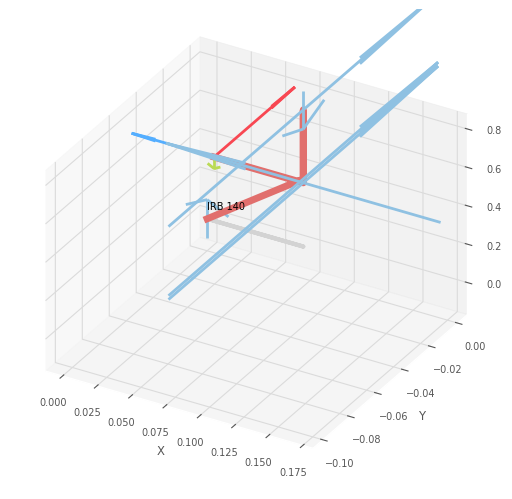

[ 0.         -1.57079633  1.57079633  0.          1.57079633 -1.57079633]


<Figure size 640x480 with 0 Axes>

In [230]:
irb140.plot(irb140.qr, backend= "pyplot")
print(irb140.qr)

### segunda posicion

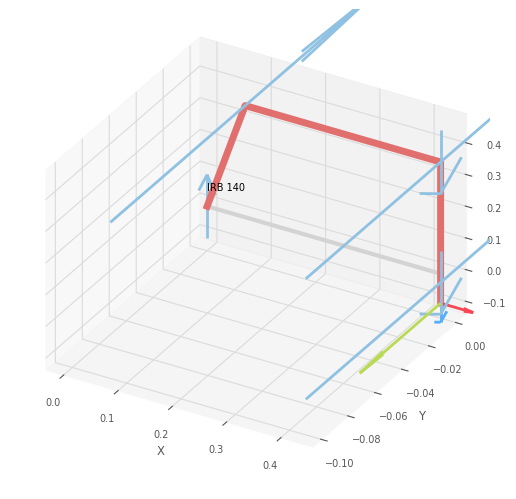

[0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

In [231]:
irb140.plot(irb140.qz, backend= "pyplot")
print(irb140.qz)

### tercera posicion


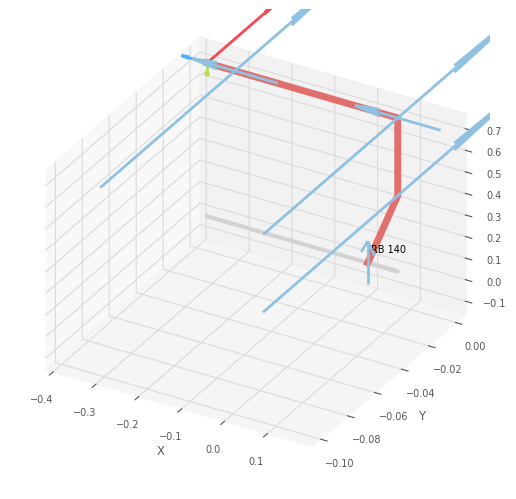

[ 0.         -1.57079633  3.14159265  0.          0.         -1.57079633]


<Figure size 640x480 with 0 Axes>

In [232]:
irb140.plot(irb140.qd, backend= "pyplot")
print(irb140.qd)

## Trayectoria de articulaciones

In [233]:
p1 = irb140.qr
p2 = irb140.qz
p3 = irb140.qd

t = np.linspace(0, 1, 10)

### trayectoria de articulaciones de posicion 1 a posicion 2

In [234]:
traj = jtraj(p1, p2, t)
times = traj.t
configurations = traj.q

In [235]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.         -1.57079633  1.57079633  0.          1.57079633 -1.57079633]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -1.55268066  1.55268066  0.          1.55268066 -1.55268066]
Tiempo: 0.2222222222222222, Configuración: [ 0.         -1.45077003  1.45077003  0.          1.45077003 -1.45077003]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -1.24112302  1.24112302  0.          1.24112302 -1.24112302]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -0.94768106  0.94768106  0.          0.94768106 -0.94768106]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -0.62311526  0.62311526  0.          0.62311526 -0.62311526]
Tiempo: 0.6666666666666666, Configuración: [ 0.        -0.3296733  0.3296733  0.         0.3296733 -0.3296733]
Tiempo: 0.7777777777777777, Configuración: [ 0.        -0.1200263  0.1200263  0.         0.1200263 -0.1200263]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -0.01811567  0.01811567  0.        

### trayectoria de articulaciones de posicion 2 a posicion 3

In [236]:
traj = jtraj(p2, p3, t)
times = traj.t
configurations = traj.q

In [237]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [0. 0. 0. 0. 0. 0.]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -0.01811567  0.03623134  0.          0.         -0.01811567]
Tiempo: 0.2222222222222222, Configuración: [ 0.        -0.1200263  0.2400526  0.         0.        -0.1200263]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -0.3296733   0.65934661  0.          0.         -0.3296733 ]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -0.62311526  1.24623053  0.          0.         -0.62311526]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -0.94768106  1.89536213  0.          0.         -0.94768106]
Tiempo: 0.6666666666666666, Configuración: [ 0.         -1.24112302  2.48224605  0.          0.         -1.24112302]
Tiempo: 0.7777777777777777, Configuración: [ 0.         -1.45077003  2.90154005  0.          0.         -1.45077003]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -1.55268066  3.10536131  0.          0.         -1.55268066]
Tiempo: 1.0, Configura

### trayectoria de articulaciones de posicion 1 a posicion 3

In [238]:
traj = jtraj(p1, p3, t)
times = traj.t
configurations = traj.q

In [239]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.         -1.57079633  1.57079633  0.          1.57079633 -1.57079633]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -1.57079633  1.588912    0.          1.55268066 -1.57079633]
Tiempo: 0.2222222222222222, Configuración: [ 0.         -1.57079633  1.69082263  0.          1.45077003 -1.57079633]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -1.57079633  1.90046963  0.          1.24112302 -1.57079633]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -1.57079633  2.19391159  0.          0.94768106 -1.57079633]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -1.57079633  2.51847739  0.          0.62311526 -1.57079633]
Tiempo: 0.6666666666666666, Configuración: [ 0.         -1.57079633  2.81191935  0.          0.3296733  -1.57079633]
Tiempo: 0.7777777777777777, Configuración: [ 0.         -1.57079633  3.02156635  0.          0.1200263  -1.57079633]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -1.57079633  3.12347698

## Trayectoria carteciana

In [240]:
p1 = irb140.fkine(irb140.qr)
p2 = irb140.fkine(irb140.qz)
p3 = irb140.fkine(irb140.qd)

t = np.linspace(0, 1, 10)
tacc = 0.1

### trayectoria carteciana de la posicion 1 a la posicion 2

In [241]:
cetraj = ctraj(p1, p2, t)
times = t
poses = cetraj
configurations = cetraj.t    

In [242]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0
Pose: 
   0         0        -1         0.005     
   1         0         0         0         
   0        -1         0         0.332     
   0         0         0         1         

configurations: [5.00000000e-03 2.84730381e-17 3.32000000e-01]
Tiempo: 0.1111111111111111
Pose: 
  -0.06477  -0.06928  -0.9955    0.01681   
   0.9955    0.06477  -0.06928   0         
   0.06928  -0.9955    0.06477   0.3202    
   0         0         0         1         

configurations: [1.68055556e-02 2.91959199e-17 3.20194444e-01]
Tiempo: 0.2222222222222222
Pose: 
  -0.2237   -0.2946   -0.9291    0.05222   
   0.9291    0.2237   -0.2946    0         
   0.2946   -0.9291    0.2237    0.2848    
   0         0         0         1         

configurations: [5.22222222e-02 3.13645652e-17 2.84777778e-01]
Tiempo: 0.3333333333333333
Pose: 
  -0.3333   -0.6667   -0.6667    0.1113    
   0.6667    0.3333   -0.6667    0         
   0.6667   -0.6667    0.3333    0.2257    
   0         0         0   

### trayectoria carteciana de la posicion 2 a la posicion 3

In [243]:
cetraj = ctraj(p2, p3, t)
times = t
poses = cetraj
configurations = cetraj.t  

In [244]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0
Pose: 
   1         0         0         0.43      
   0        -1         0         0         
   0         0        -1        -0.093     
   0         0         0         1         

configurations: [ 4.30000000e-01  5.44967826e-17 -9.30000000e-02]
Tiempo: 0.1111111111111111
Pose: 
   0.9955   -0.06928   0.06477   0.4076    
  -0.06477  -0.9955   -0.06928   0         
   0.06928   0.06477  -0.9955   -0.07064   
   0         0         0         1         

configurations: [ 4.07638889e-01  5.31275594e-17 -7.06388889e-02]
Tiempo: 0.2222222222222222
Pose: 
   0.9291   -0.2946    0.2237    0.3406    
  -0.2237   -0.9291   -0.2946    0         
   0.2946    0.2237   -0.9291   -0.003556  
   0         0         0         1         

configurations: [ 3.40555556e-01  4.90198899e-17 -3.55555556e-03]
Tiempo: 0.3333333333333333
Pose: 
   0.6667   -0.6667    0.3333    0.2288    
  -0.3333   -0.6667   -0.6667    0         
   0.6667    0.3333   -0.6667    0.1082    
   0         0    

### trayectoria carteciana de la posicion 1 a la posicion 3

In [245]:
cetraj = ctraj(p1, p3, t)
times = t
poses = cetraj
configurations = cetraj.t  

In [246]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0
Pose: 
   0         0        -1         0.005     
   1         0         0         0         
   0        -1         0         0.332     
   0         0         0         1         

configurations: [5.00000000e-03 2.84730381e-17 3.32000000e-01]
Tiempo: 0.1111111111111111
Pose: 
   0         0        -1        -0.005556  
   1         0         0         0         
   0        -1         0         0.3426    
   0         0         0         1         

configurations: [-5.55555556e-03  2.78266967e-17  3.42555556e-01]
Tiempo: 0.2222222222222222
Pose: 
   0         0        -1        -0.03722   
   1         0         0         0         
   0        -1         0         0.3742    
   0         0         0         1         

configurations: [-3.72222222e-02  2.58876726e-17  3.74222222e-01]
Tiempo: 0.3333333333333333
Pose: 
   0         0        -1        -0.09      
   1         0         0         0         
   0        -1         0         0.427     
   0         0       

## Trayectoria de movimiento

In [247]:
p1 = irb140.qr
p2 = irb140.qz
p3 = irb140.qd

t = np.linspace(0, 1, 10)

### trayectoria de movimiento de la posicion 1 a la posicion 2

In [248]:
metraj = mtraj(quintic, p1, p2, t)
times = metraj.t
configurations = metraj.q

In [249]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.         -1.57079633  1.57079633  0.          1.57079633 -1.57079633]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -1.55268066  1.55268066  0.          1.55268066 -1.55268066]
Tiempo: 0.2222222222222222, Configuración: [ 0.         -1.45077003  1.45077003  0.          1.45077003 -1.45077003]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -1.24112302  1.24112302  0.          1.24112302 -1.24112302]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -0.94768106  0.94768106  0.          0.94768106 -0.94768106]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -0.62311526  0.62311526  0.          0.62311526 -0.62311526]
Tiempo: 0.6666666666666666, Configuración: [ 0.        -0.3296733  0.3296733  0.         0.3296733 -0.3296733]
Tiempo: 0.7777777777777777, Configuración: [ 0.        -0.1200263  0.1200263  0.         0.1200263 -0.1200263]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -0.01811567  0.01811567  0.        

### trayectoria de movimiento de la posicion 2 a la posicion 3

In [250]:
metraj = mtraj(quintic, p2, p3, t)
times = metraj.t
configurations = metraj.q

In [251]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.00000000e+00  3.62349040e-14 -7.24698079e-14  0.00000000e+00
  0.00000000e+00  3.62349040e-14]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -0.01811567  0.03623134  0.          0.         -0.01811567]
Tiempo: 0.2222222222222222, Configuración: [ 0.        -0.1200263  0.2400526  0.         0.        -0.1200263]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -0.3296733   0.65934661  0.          0.         -0.3296733 ]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -0.62311526  1.24623053  0.          0.         -0.62311526]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -0.94768106  1.89536213  0.          0.         -0.94768106]
Tiempo: 0.6666666666666666, Configuración: [ 0.         -1.24112302  2.48224605  0.          0.         -1.24112302]
Tiempo: 0.7777777777777777, Configuración: [ 0.         -1.45077003  2.90154005  0.          0.         -1.45077003]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -1.5

### trayectoria de movimiento de la posicion 1 a la posicion 3

In [252]:
metraj = mtraj(quintic, p1, p3, t)
times = metraj.t
configurations = metraj.q

In [253]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #irb140.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.         -1.57079633  1.57079633  0.          1.57079633 -1.57079633]
Tiempo: 0.1111111111111111, Configuración: [ 0.         -1.57079633  1.588912    0.          1.55268066 -1.57079633]
Tiempo: 0.2222222222222222, Configuración: [ 0.         -1.57079633  1.69082263  0.          1.45077003 -1.57079633]
Tiempo: 0.3333333333333333, Configuración: [ 0.         -1.57079633  1.90046963  0.          1.24112302 -1.57079633]
Tiempo: 0.4444444444444444, Configuración: [ 0.         -1.57079633  2.19391159  0.          0.94768106 -1.57079633]
Tiempo: 0.5555555555555556, Configuración: [ 0.         -1.57079633  2.51847739  0.          0.62311526 -1.57079633]
Tiempo: 0.6666666666666666, Configuración: [ 0.         -1.57079633  2.81191935  0.          0.3296733  -1.57079633]
Tiempo: 0.7777777777777777, Configuración: [ 0.         -1.57079633  3.02156635  0.          0.1200263  -1.57079633]
Tiempo: 0.8888888888888888, Configuración: [ 0.         -1.57079633  3.12347698

## Conclusiones

* No fue posible realizar el Moveit completo del puma560 debido a pesar de que se utilizara el urdf que se encontraba en la libreria de robotic tootlbox, este repositorio no contaba con la geometría de colisiones, sin embargo, todos los demás análisis si fueron posibles.

* No se pudo realizar el Pick and Place del irb140 debido a que este no constaba con una garra, y aunque se trató de copiar y pegar mediante otros URDFs que constaban ya con una, el archivo dejaba de funcionar, además de que era necesario utilizar un plugin de Gazebo control, y el assistant de moveit ya no generaba archivos de simulación o launch para gazebo.

* Se tuvo que hacer los plots a través de pyplot, porque swift consumía muchos recursos computacionales y también porque irb140 no constaba con una clase URDF ya predeterminada con la librería Robotic toolbox.

* Respecto a la cinemática inversa, su implementación fue bastante simple ya que la librería disponía con el DH de ambos robots, por lo que hacer tanto la cinemática directa, e inversa era rápido.

* En el apartado de trayectorias, a pesar de que fueron temáticas nuevas se lograron implementar mediante la librería.

* Se pudo evidenciar que la librería de robotic toolbox está más desarrollada en Matlab que en Python.


